In [7]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randn

%matplotlib inline

# SA(2) invariant signatures
We are considering transformations in $SA(2)$ of the following form:

\begin{equation}
   \hat{x}_i = a_{ij} x_j + b_i
\end{equation}

where $\det a = 1$, or in vector notation $\hat{x} = Ax + b$, $\det A = 1$. Our image $f : \mathbb{R}^2 \mapsto \mathbb{R}$ transforms as $f(x) = \hat{f}(\hat{x})$. Then, we have the following:

\begin{align}
    f_{,i} &= \hat{f}_{,k}a_{ki}, & \nabla{f} &= A^T \nabla{\hat{f}} \\
    f_{,ij} &= \hat{f}_{,kl} a_{ki} a_{lj} & \nabla^2 f &= A^T \nabla^2 \hat{f} A
\end{align}

We can see that in vector notation, we have the following invariants under SA(2) (at $x$ on the left and $\hat{x}$ on the right:
1. $I_0 = f(x) = \hat{f}(\hat{x})$
2. $I_1 = \det \nabla^2 f(x) = \det(A^T)\det \nabla^2 \hat{f} \det(A) = \det \nabla^2 \hat{f}$
3. $I_2 =(\nabla f)^T (\nabla^2 f)^{-1} (\nabla f) = (\nabla \hat{f})^T A A^{-1} (\nabla^2 \hat{f})^{-1} A^{-T} A^T \nabla{\hat f} = (\nabla \hat{f})^T (\nabla^2 \hat{f})^{-1} \nabla \hat{f}$

The third invariant is in fact invariant under $A(2)$, not just $SA(2)$. However, for $SA(2)$ we can replace it with a polynomial by multiplying by $\det \nabla^2 f$, in which case $(\nabla^2 f)^{-1}$ is replaced by $\text{adj} \nabla^2 f$.

3a. $I_2 = (\nabla f)^T \text{adj} \nabla^2 f \nabla f = f_{yy} f_x^2 - 2f_{xy}f_x f_y + f_{xx} f_y^2 $

## Update: transvectants
Let's also check to see whether Robert's transvectant formulae also work (the first two being ones we already know):
1. $f_{xx} f_{yy} - f_{xy}^2$
2. $f_y^2 f_{xx} - 2f_x f_y f_{xy} + f_x^2 f_{yy}$
3. $f_{yy} f_{xxy}^2 - f_{yy} f_{xxx} f_{xyy} - f_{xy} f_{xxy} f_{xyy} + f_{xx} f_{xyy}^2 + f_{xy} f_{xxx} f_{yyy} - f_{xx} f_{xxy} f_{yyy}$
4. $f_y f_{yy} f_{xxx} - 2f_y f_{xy} f_{xxy} - f_x f_{yy} f_{xxy} + f_y  f_{xx} f_{xyy} + 2f_x f_{xy} f_{xyy} - f_x  f_{xx} f_{yyy}$

In [34]:
def SA2transvectants(F, h=1):
    """ All the degree three and lower transvectants"""
    Fx, Fy = np.gradient(F, h)
    Fxx, Fxy = np.gradient(Fx, h)
    Fyx, Fyy = np.gradient(Fy, h)
    Fxxx, Fxxy = np.gradient(Fxx, h)
    Fxyx, Fxyy = np.gradient(Fxy, h)
    Fyyx, Fyyy = np.gradient(Fyy, h)
    
    I0 = F
    I1 = Fxx*Fyy - Fxy**2
    I2 = Fy**2*Fxx - 2*Fx*Fy*Fxy + Fx**2*Fyy
    I3 = Fyy*Fxxy**2 - Fyy*Fxxx*Fxyy - Fxy*Fxxy*Fxyy + Fxx*Fxyy**2 + Fxy*Fxxx*Fyyy - Fxx*Fxxy*Fyyy
    I4 = Fy*Fyy*Fxxx - 2*Fy*Fxy*Fxxy - Fx*Fyy*Fxxy + Fy*Fxx*Fxyy + 2*Fx*Fxy*Fxyy - Fx*Fxx*Fyyy
    
    return (I0, I1, I2, I3, I4)

## Test image
We use as our test function the function `f(x, y)` defined below

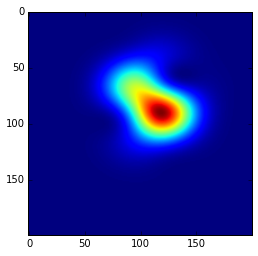

In [166]:
def f(x, y):
    return 0.5*(1 + np.sin(4*x) * np.cos(7*y)) * 2*np.exp(-10*((x - 0.1)**2 + (y+0.2)**2))

h = 0.01
X, Y = np.meshgrid(np.arange(-1, 1, h), np.arange(-1, 1, h))
F0 = f(X, Y)
plt.imshow(F0)

## Transformation
We generate a random equiaffine transformation $x \mapsto Ax + b$, $\det A = 1$ as follows:


In [167]:
from numpy.random import rand, randn

A = np.random.randn(2,2)
if np.linalg.det(A) < 0:
    A[:, 1] = -A[:, 1]
A = A / np.sqrt(np.linalg.det(A))
b = 0.2 * randn(2)
Ainv = np.linalg.inv(A)
binv = -np.linalg.solve(A, b)


The image and its transformation are plotted below


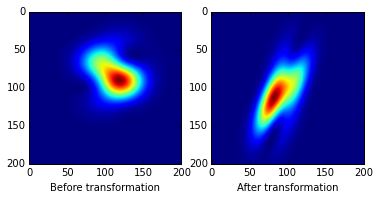

In [168]:
F1 = f(Ainv[0,0]*X + Ainv[0,1]*Y + binv[0], Ainv[1,0]*X + Ainv[1,1]*Y + binv[1])

#a, b, c, d, e, ff, g, h, i = randn(9)
#F1 = f((a*X + b*Y + c)/(g*X + h*Y + i), (d*X + e*Y + ff)/(g*X + h*Y + i))

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(F0)
axarr[0].set_xlabel('Before transformation')
axarr[1].imshow(F1)
axarr[1].set_xlabel('After transformation')

## Compare signatures of the two images
We compare the signatures for a few contours (with respect to the function value)


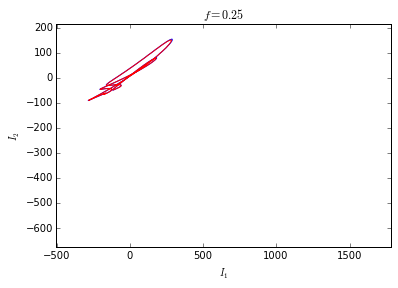

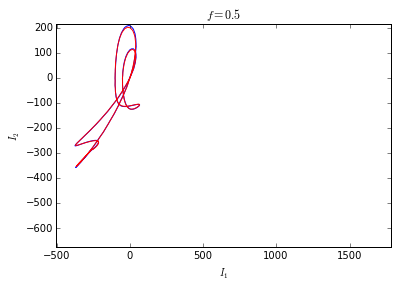

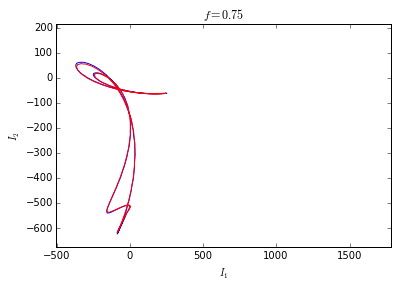

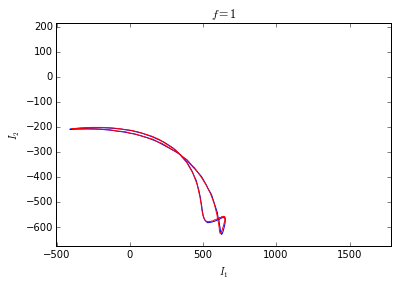

In [169]:
%matplotlib inline
sig0 = SA2transvectants(F0, h)
sig1 = SA2transvectants(F1, h)
contour_levels = [0.25, 0.5, 0.75, 1]

i0 = 1
i1 = 2

for level in contour_levels:
    plt.figure()
    plt.contour(sig0[i0], sig0[i1], sig0[0], levels=[level], colors='blue')
    plt.contour(sig1[i0], sig1[i1], sig1[0], levels=[level], colors='red')
    plt.xlabel('$I_1$')
    plt.ylabel('$I_2$')
    plt.title('$f = {}$'.format(level))


## Currents

We need the triangle areas first



In [170]:
def triangle_areas(I0, I1):
    lower = 0.5 * (I0[0:-1, 1:] * (I1[1:, 0:-1] - I1[1:, 1:]) + 
                   I0[1:, 0:-1] * (I1[1:, 1:] - I1[0:-1, 1:]) +
                   I0[1:, 1:] * (I1[0:-1, 1:] - I1[1:, 0:-1]))
        
    upper = 0.5 * (I0[0:-1, 0:-1] * (I1[1:, 0:-1] - I1[1:, 1:]) + 
                   I0[1:, 0:-1] * (I1[1:, 1:] - I1[0:-1, 0:-1]) +
                   I0[1:, 1:] * (I1[0:-1, 0:-1] - I1[1:, 0:-1]))
        
    return lower, upper

def lower_centroid(Ia):
    return 1./3. * (Ia[0:-1, 1:] + Ia[1:, 0:-1] + Ia[1:, 1:])
    
def upper_centroid(Ia):
    return 1./3. * (Ia[0:-1, 0:-1] + Ia[0:-1, 1:] + Ia[1:, 0:-1])
    

def currents(invariants, N):
    # Compute centroids
    c_l = [lower_centroid(Ia) for Ia in invariants]
    c_u = [upper_centroid(Ia) for Ia in invariants]
    
    # Compute triangle areas 
    I0, I1, I2 = invariants[:]
    dxdy_l, dxdy_u = triangle_areas(I0, I1)
    dydz_l, dydz_u = triangle_areas(I1, I2)
    dxdz_l, dxdz_u = triangle_areas(I0, I2)
    
    C = []
    for m in range(N + 1):
        for n in range(N + 1 - m):
            for k in range(N + 1 - m - n):
                integrand_l = c_l[0]**m * c_l[1]**n * c_l[2]**k 
                integrand_u = c_u[0]**m + c_u[1]**n * c_u[2]**k
           
                C.append([m, n, k, 1, (integrand_l * dxdy_l + integrand_u * dxdy_u).sum()])
                C.append([m, n, k, 2, (integrand_l * dydz_l + integrand_u * dydz_u).sum()])
                C.append([m, n, k, 3, (integrand_l * dxdz_l + integrand_u * dxdz_u).sum()])
    xc = np.array([c[4] for c in C])
    return C, xc

In [189]:
S0 = [sig0[0], sig0[1], sig0[2]]
S1 = [sig0[0], sig0[1], sig0[2]]

for i in range(3):
    s0 = S0[i]
    s1 = S1[i]
    maxval = max(s0.max(), s1.max())
    minval = min(s0.min(), s1.min())
    meanval = np.mean(np.array([s0.mean(), s1.mean()]))
    S0[i] = (S0[i] - meanval) / (maxval - minval)
    S1[i] = (S1[i] - meanval) / (maxval - minval)

print S1[1].max()
C0, xc0 = currents(S0, 1)
C1, xc1 = currents(S1, 1)

print xc0
print xc1

0.780629463473
[-0.0228735  -0.04839016 -0.01549177  0.00470027 -0.00473545 -0.00165493
 -0.01169573 -0.02462872 -0.01882019 -0.01753223 -0.02583813 -0.01437864]
[-0.0228735  -0.04839016 -0.01549177  0.00470027 -0.00473545 -0.00165493
 -0.01169573 -0.02462872 -0.01882019 -0.01753223 -0.02583813 -0.01437864]
